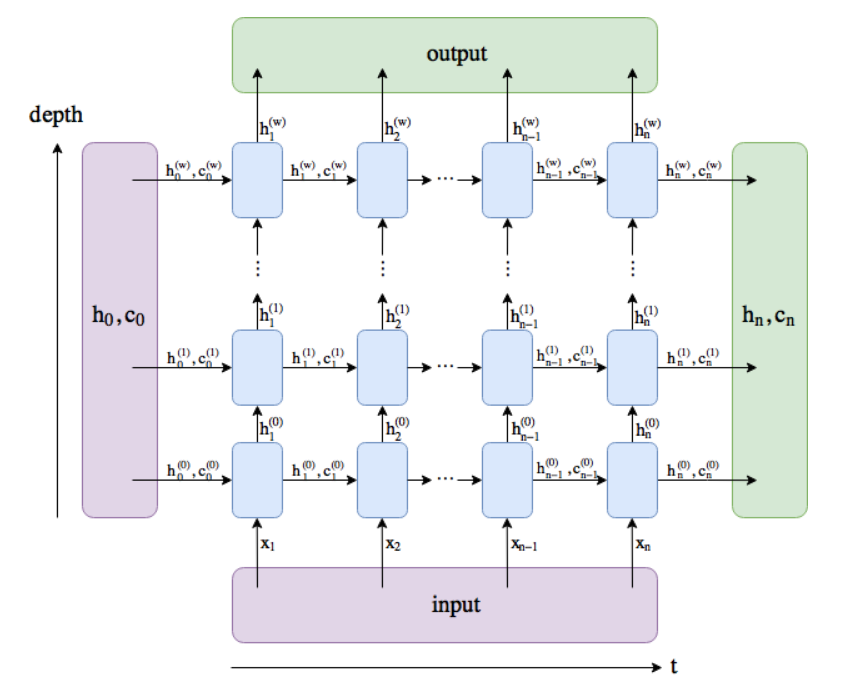

In [1]:
import import_ipynb

In [2]:
import torch
from torch import nn, optim
import pandas as pd
from collections import Counter
import argparse
import numpy as np
from torch.utils.data import DataLoader
from vocab_building import load_tokenized_file, load_vocab, decode_vocab

importing Jupyter notebook from vocab_building.ipynb


In [3]:
vocab = load_vocab("feb_2023_peter_pan_vocab.pt")

Finished.
Vocabulary sizes:
5228


In [4]:
raw_tokens = load_tokenized_file("peter_pan_Transformer_tok.pkl")

In [11]:
print(len(vocab))

5228


In [ ]:
BATCH_SIZE=16
TRAIN_TOKEN_LEN=256

In [ ]:
def data_loader_that_doesnt_overlap(batch_size=BATCH_SIZE, num_discard_toks=TRAIN_TOKEN_LEN):
    num_samples = max(1, (len(raw_tokens) // TRAIN_TOKEN_LEN))
    num_batches = max(1, num_samples // batch_size)
    # num_batches = 1
    discard_tokens = random.randint(0, num_discard_toks)
    for i in range(num_batches):

        samples = [raw_tokens[(i * TRAIN_TOKEN_LEN * batch_size) + (j * TRAIN_TOKEN_LEN) + discard_tokens:(i * TRAIN_TOKEN_LEN * batch_size) + (j * TRAIN_TOKEN_LEN) + TRAIN_TOKEN_LEN + discard_tokens + 1] for j in
                   range(batch_size)]
        samples = torch.vstack([torch.as_tensor(samples)])
        str_samples = [str_tokens[(i * TRAIN_TOKEN_LEN * batch_size) + (j * TRAIN_TOKEN_LEN) + discard_tokens:(i * TRAIN_TOKEN_LEN * batch_size) + (j * TRAIN_TOKEN_LEN) + TRAIN_TOKEN_LEN + discard_tokens] for j in
                   range(batch_size)]
        yield Batch(samples, str_samples, 0, VOCAB_SIZE)

Try using torchtext stuff for this:

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        sequence_length,
    ):
        self.sequence_length = sequence_length
        self.words = self.load_words() # this is just a list of all the words in sequence
    
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]
        #print('word indexes: ', torch.tensor(self.words_indexes[0:4]).size())
        #print('word indexes size: ', self.words_indexes.size)

    def load_words(self):
        train_df = pd.read_csv('../data/reddit-cleanjokes.csv')
        text = train_df['Joke'].str.cat(sep=' ')
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        #print('INDEX: ', index)
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]), # x
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]), # y
        )

In [47]:
class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        #print('embed dim: ', embed.size()) # 256, 4, 128 - batch_size, sequence_length, input_size
        #print('prev_state dim: ', prev_state[0].size()) # 3, 4, 128 - num_layers, batch_size, hidden_size
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

In [7]:
def train(dataset, model, max_epochs, batch_size, sequence_length):
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(max_epochs):
        
        for batch, (x, y) in enumerate(dataloader):
            state_h, state_c = model.init_state(batch_size)
            # Batch_size is 256
            # Sequence length is 4
            # This enumerate grabs an entire sequential batch, each element of the batch being 4 tokens long.
            #print('Inside training loop')
            #print('batch is: ', batch)
            #print('x: ', x.size())  # (256, 4)
            #print('y: ', y.size()) # (256, 4)
            #print('shape of hidden: ', state_h.size()) # 3, 4, 128 -- needs to be num_layers, batch_size, hidden_size
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            #state_h = state_h.detach()
            #state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

In [48]:
def predict(dataset, model, text, next_words=100):
    model.eval()

    words = text.split(' ')
    initial_input = torch.tensor([dataset.word_to_index[w] for w in words]) # 1, 4

    state_h, state_c = model.init_state(1) # 3, 1, 128, num_layers, batch_size, lstm_size

    #print('state_h.size(): ', state_h.size())

    # Prime generation by feeding in initial input:
    for p in range(len(words)-1):
        #print(initial_input[p].view(1,-1))
        #print(initial_input[p].view(1,-1)[:,0].item())
        #print(dataset.index_to_word[initial_input[p].view(1,-1)[:,0].item()])
        _, (state_h, state_c) = model(initial_input[p].view(1,-1), (state_h, state_c))

    last_token = initial_input[-1]
    for i in range(0, next_words):
        #print('x.size(): ', x.size()) # 1, 4
        y_pred, (state_h, state_c) = model(last_token.view(1,-1), (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        #word_index = np.random.choice(len(last_word_logits), p=p)
        word_index = torch.multinomial(p, 1)[0]
        words.append(dataset.index_to_word[word_index])

        last_token = torch.tensor([word_index])

    return words

In [52]:
max_epochs = 50
batch_size = 256
sequence_length = 4

# Each epoch goes through all of the training data
# Each batch is 256
# The number of batches done in an epoch is the iterations?
# How does it grab the batch?
# What is being fed in?

dataset = Dataset(sequence_length)
model = Model(dataset)

train(dataset, model, max_epochs, batch_size, sequence_length)


{'epoch': 0, 'batch': 0, 'loss': 8.844823837280273}
{'epoch': 0, 'batch': 1, 'loss': 8.842288970947266}
{'epoch': 0, 'batch': 2, 'loss': 8.8344144821167}
{'epoch': 0, 'batch': 3, 'loss': 8.83028507232666}
{'epoch': 0, 'batch': 4, 'loss': 8.826757431030273}
{'epoch': 0, 'batch': 5, 'loss': 8.819011688232422}
{'epoch': 0, 'batch': 6, 'loss': 8.815603256225586}
{'epoch': 0, 'batch': 7, 'loss': 8.812178611755371}
{'epoch': 0, 'batch': 8, 'loss': 8.805169105529785}
{'epoch': 0, 'batch': 9, 'loss': 8.796542167663574}
{'epoch': 0, 'batch': 10, 'loss': 8.78808879852295}
{'epoch': 0, 'batch': 11, 'loss': 8.777016639709473}
{'epoch': 0, 'batch': 12, 'loss': 8.765735626220703}
{'epoch': 0, 'batch': 13, 'loss': 8.760106086730957}
{'epoch': 0, 'batch': 14, 'loss': 8.72219467163086}
{'epoch': 0, 'batch': 15, 'loss': 8.6959867477417}
{'epoch': 0, 'batch': 16, 'loss': 8.654666900634766}
{'epoch': 0, 'batch': 17, 'loss': 8.6157808303833}
{'epoch': 0, 'batch': 18, 'loss': 8.550073623657227}
{'epoch': 0,

In [71]:
print(predict(dataset, model, text='How did the Pillsbury Dough Boy Die?'))

['How', 'did', 'the', 'Pillsbury', 'Dough', 'Boy', 'Die?', 'A', 'potato', 'wedge!', '~Skip', 'I', 'found', 'what', 'does', 'it', 'take', 'to', 'see', 'an', 'EXcavator', 'on', 'then', "I'd", 'joined', 'your', 'order?"', 'What', 'do', 'you', 'say', 'into', 'the', 'most', 'important', "...that's", 'about', 'the', 'book', 'say', 'when', 'he', 'got', 'giddy', 'up."', 'What', 'do', 'you', 'call', 'an', 'octopus', 'laugh?', 'Ten', 'tickles', 'Do', 'you', 'threw', 'four', 'loaves', 'of', 'blood?', 'how', 'to', 'get', 'his', 'tie', 'got', 'Are', 'you', 'want', 'a', 'right.', 'The', 'monkey.', "*They're", 'Not', 'a', 'reason', 'food?', 'Ice', 'For', 'people', 'have', 'believe', 'in', 'every', 'doll,', 'in', 'college?', 'He', '?', "I'll", 'were', 'arch', 'Superman', 'I', 'sent', 'outstanding.', 'Never', 'cute', 'male', 'Omg', 'Guardians', 'What', 'did', 'the', 'horse']
